In [144]:
import numpy as np, matplotlib.pyplot as plt
import scipy.optimize as optimize
import matplotlib as mpl
from astropy.io import ascii as asc
from astropy.table import Table
from analysis.composite_errors import composite_errors

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0

In [145]:
# reading in data generated by EBV_corrections.py
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

stlr_mass = np.array(corr_tbl['stlr_mass'])
filts = np.array(corr_tbl['filt'])
sfr = np.array(corr_tbl['met_dep_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])
corr_sfrs = sfr+filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

# defining a flux sigma and mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & (stlr_mass >= CUTOFF_MASS))[0]
n = len(good_sig_iis)

In [146]:
sigmas = corr_tbl['meas_errs'][good_sig_iis].data
mass = stlr_mass[good_sig_iis]
sfrs = corr_sfrs[good_sig_iis]

z_sp = zspec0[good_sig_iis]
badz_iis = np.array([x for x in range(len(z_sp)) if z_sp[x] < 0 or z_sp[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}
ffs = filts[good_sig_iis]
for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    z_sp[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1
    
mz_data = np.vstack([mass, z_sp]).T

In [147]:
eqn0 = r'$\log(SFR) = \alpha \log(M) + \beta$'
def func0(data, a, b):
    return a*data + b

eqn1 = r'$\log(SFR) = \alpha \log(M) + \beta z + \gamma$'
def func1(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

eqn2 = r'$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta$'
def func2(x, a1, a2, b):
    return np.piecewise(x, [x < m_char], [lambda x:a1*(x-m_char)+b, lambda x:a2*(x-m_char)+b])
    
eqn3 = r'$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta z + \gamma$'
def func3(x, a1, a2, b, c):
    m = x[:,0]
    z = x[:,1]
    return np.select([m < m_char, m >= m_char], [a1*(m-m_char)+b*z+c, a2*(m-m_char)+b*z+c])

## fitting without piecewise functions

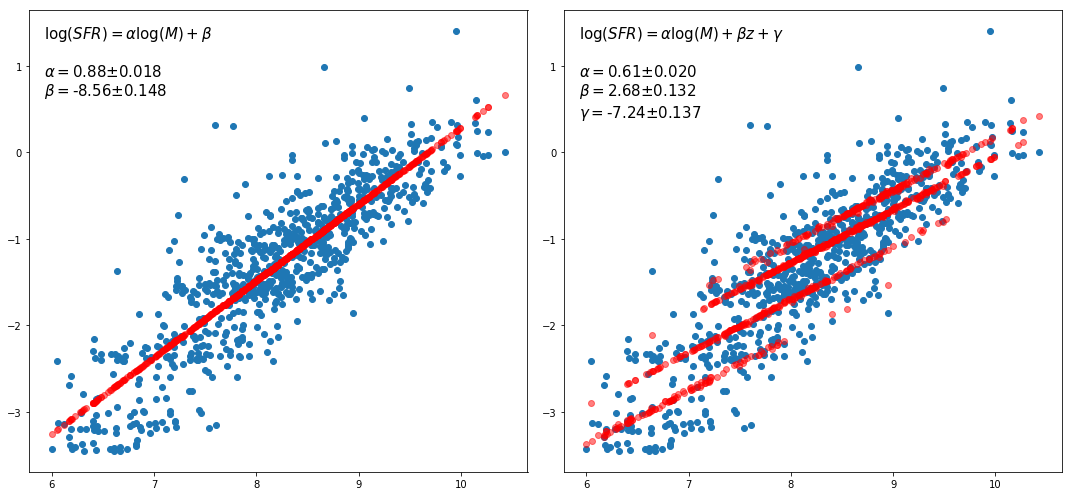

In [148]:
f, axes = plt.subplots(1,2)
# axarr = np.ndarray.flatten(axes)
f.set_size_inches(15,7)

for ax, func, eqn_str in zip(axes, [func0, func1], [eqn0, eqn1]):
    ax.plot(mass, sfrs, 'o')
    
    if 'gamma' not in eqn_str: # just a line w/o redshift dependence
        params, pcov = optimize.curve_fit(func, mass, sfrs)
        perr = np.sqrt(np.diag(pcov))
        ax.plot(mass, func(mass, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
            '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1],
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # w/ redshift dependence
        params, pcov = optimize.curve_fit(func, mz_data, sfrs)
        perr = np.sqrt(np.diag(pcov))
        ax.plot(mass, func(mz_data, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
            '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
            '\n'+r'$\gamma=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2],
            transform=ax.transAxes,fontsize=15,ha='left',va='top')


plt.tight_layout()
plt.show()

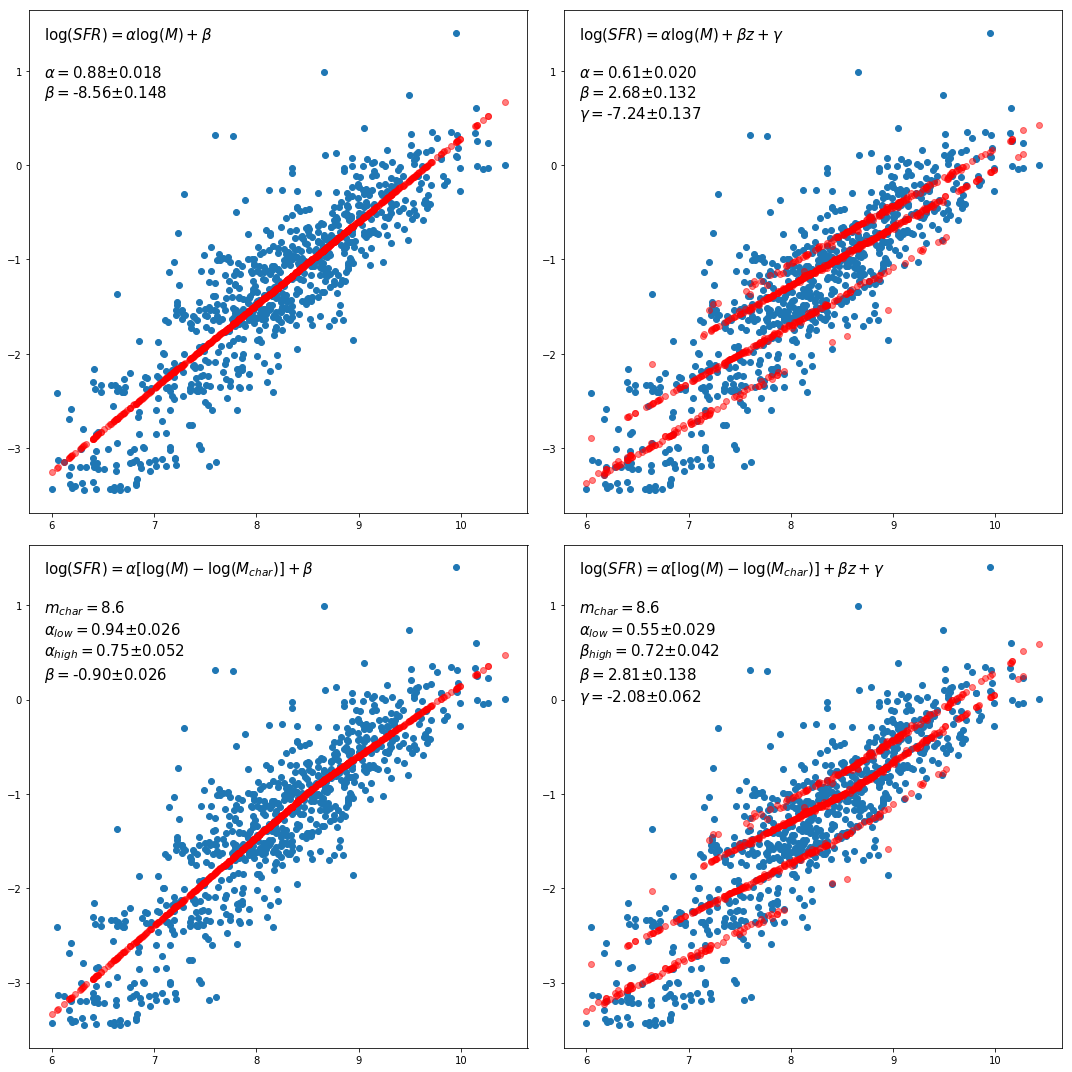

In [168]:
f, axes = plt.subplots(2,2)
axarr = np.ndarray.flatten(axes)
f.set_size_inches(15,15)

for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3], [eqn0, eqn1, eqn2, eqn3]):
    ax.plot(mass, sfrs, 'o')
    if 'char' not in eqn_str:
        if 'gamma' not in eqn_str: # just a line w/o redshift dependence
            params, pcov = optimize.curve_fit(func, mass, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mass, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')
        else: # w/ redshift dependence
            params, pcov = optimize.curve_fit(func, mz_data, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mz_data, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
                '\n'+r'$\gamma=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        if 'gamma' not in eqn_str:
            m_char = 8.6 # 9.1
            params, pcov = optimize.curve_fit(func, mass, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mass, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$m_{char}=$'+str(m_char)+
                '\n'+r'$\alpha_{low}=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\alpha_{high}=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
                '\n'+r'$\beta=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')
        else:
            m_char = 8.6
            params, pcov = optimize.curve_fit(func, mz_data, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mz_data, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$m_{char}=$'+str(m_char)+
                '\n'+r'$\alpha_{low}=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\beta_{high}=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
                '\n'+r'$\beta=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2]+
                '\n'+r'$\gamma=$'+'%.2f'%params[3]+r'$\pm$'+'%.3f'%perr[3],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')

plt.tight_layout()
plt.show()

$$\log(SFR) = \alpha \log(M) + \beta$$

In [149]:
k = 2 # (a,b)
nu = n - k

In [150]:
params, pcov = optimize.curve_fit(func0, mass, sfrs)
a = params[0]
b = params[1]

rss = np.sum( (sfrs - func0(mass, *params))**2 )  # residual sum of squares
tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
r2 = 1 - (rss / tss)    # r-squared
r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
rmse = np.std((sfrs - func0(mass, *params)))      # root mean square error
old_chi2 = np.sum( (func0(mass, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
chi2 = np.sum(((sfrs - func0(mass, *params))**2)/sigmas**2)

tt = Table([[a], [b], [r2], [r2adj], [rmse], [old_chi2], [old_chi2/nu], [chi2], [chi2/nu]], 
       names=['a', 'b', r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
              'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

a,b,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.884756292448,-8.56194269991,0.756949833503,0.756321796897,0.438850307589,588.150020339,0.758903252051,340623.613687,439.514340241


$$\log(SFR) = \alpha \log(M) + \beta z + \gamma$$

In [151]:
k = 3 # (a,b,c)
nu = n - k

In [152]:
params, pcov = optimize.curve_fit(func1, mz_data, sfrs)
a = params[0]
b = params[1]
c = params[2]

rss = np.sum( (sfrs - func1(mz_data, *params))**2 )  # residual sum of squares
tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
r2 = 1 - (rss / tss)    # r-squared
r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
rmse = np.std((sfrs - func1(mz_data, *params)))      # root mean square error
old_chi2 = np.sum( (func1(mz_data, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
chi2 = np.sum(((sfrs - func1(mz_data, *params))**2)/sigmas**2)

tt = Table([[a], [b], [c], [r2], [r2adj], [rmse], [old_chi2], [old_chi2/nu], [chi2], [chi2/nu]], 
       names=['a', 'b', 'c', r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
              'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

a,b,c,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.612080547123,2.68173753565,-7.24285036309,0.841156780689,0.840540312826,0.354774817929,653.578818498,0.844417078163,419946.218086,542.566173238


## fitting with a piecewise powerlaw fit (no redshift dependence)

$$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta$$

In [153]:
k = 3 # (a1,a2,b)
nu = n - k

In [154]:
a_low_arr, a_high_arr, b_arr, r2_arr, r2adj_arr, rmse_arr, old_chi2_arr, chi2_arr = [],[],[],[],[],[],[],[]
m_char_arr = np.arange(8.0,10.1,0.1)

for m_char in m_char_arr:
    def piecewise_linear(x, a1, a2, b):
        return np.piecewise(x, [x < m_char], [lambda x:a1*(x-m_char)+b, lambda x:a2*(x-m_char)+b])
    
    params, pcov = optimize.curve_fit(piecewise_linear, mass, sfrs)
    a1 = params[0]
    a2 = params[1]
    b = params[2]

    a_low_arr.append('%.2f'%a1+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[0])
    a_high_arr.append('%.2f'%a2+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[1])
    b_arr.append('%.2f'%b+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[2])
    
    rss = np.sum( (sfrs - piecewise_linear(mass, *params))**2 )  # residual sum of squares
    tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
    r2 = 1 - (rss / tss)    # r-squared
    r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
    rmse = np.std((sfrs - piecewise_linear(mass, *params)))      # root mean square error
    old_chi2 = np.sum( (piecewise_linear(mass, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
    chi2 = np.sum(((sfrs - piecewise_linear(mass, *params))**2)/sigmas**2)

    r2_arr.append(np.around(r2,6))
    r2adj_arr.append(np.around(r2adj,6))
    rmse_arr.append(np.around(rmse,6))
    old_chi2_arr.append(np.around(old_chi2,6))
    chi2_arr.append(np.around(chi2,6))
    
tt = Table([m_char_arr, a_low_arr, a_high_arr, b_arr, r2_arr, r2adj_arr, rmse_arr, 
            old_chi2_arr, np.around(np.array(old_chi2_arr)/nu,4), chi2_arr, np.around(np.array(chi2_arr)/nu,4)], 
           names=['m'+r'$_{\rm char}$', 'a'+r'$_{\rm low}$', 'a'+r'$_{\rm high}$', 'b',  
                  r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
                  'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])

tt

m$_{\rm char}$,a$_{\rm low}$,a$_{\rm high}$,b,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,str13,str14,str14,float64,float64,float64,float64,float64,float64,float64
8.0,0.99$\pm$0.04,0.80$\pm$0.03,-1.41$\pm$0.03,0.760143,0.759212,0.435958,590.631014,0.7631,332347.774373,429.3899
8.1,0.98$\pm$0.04,0.79$\pm$0.03,-1.33$\pm$0.03,0.759933,0.759002,0.436149,590.468133,0.7629,331089.499645,427.7642
8.2,0.97$\pm$0.03,0.79$\pm$0.04,-1.24$\pm$0.03,0.759747,0.758814,0.436318,590.323198,0.7627,329486.914293,425.6937
8.3,0.96$\pm$0.03,0.78$\pm$0.04,-1.16$\pm$0.03,0.759726,0.758794,0.436337,590.307352,0.7627,327867.215938,423.6011
8.4,0.95$\pm$0.03,0.77$\pm$0.04,-1.07$\pm$0.03,0.759668,0.758736,0.436389,590.262311,0.7626,326763.152584,422.1746
8.5,0.95$\pm$0.03,0.76$\pm$0.05,-0.98$\pm$0.03,0.759448,0.758514,0.436589,590.09083,0.7624,326156.083495,421.3903
8.6,0.94$\pm$0.03,0.75$\pm$0.05,-0.90$\pm$0.03,0.759248,0.758314,0.43677,589.93593,0.7622,325312.182396,420.3
8.7,0.93$\pm$0.03,0.74$\pm$0.06,-0.81$\pm$0.03,0.759119,0.758184,0.436887,589.835553,0.7621,324171.063841,418.8257
8.8,0.93$\pm$0.02,0.72$\pm$0.06,-0.73$\pm$0.03,0.759095,0.75816,0.43691,589.816698,0.762,323246.512229,417.6312


## fitting with a piecewise powerlaw fit (redshift dependence)

$$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta z + \gamma$$

In [155]:
k = 4 # (a1,a2,b,c)
nu = n-k

In [156]:
a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, old_chi2_arr, chi2_arr = [],[],[],[],[],[],[],[],[]
# m_char_arr = np.arange(6.1,10.5,0.1)
# m_char_arr = np.arange(9.0,9.6,0.1)
m_char_arr = np.arange(8.0,10.1,0.1)
# m_char_arr = [9.2]

for m_char in m_char_arr:
    def piecewise_linear_z(x, a1, a2, b, c):
        m = x[:,0]
        z = x[:,1]
        return np.select([m < m_char, m >= m_char], [a1*(m-m_char)+b*z+c, a2*(m-m_char)+b*z+c])
    
    guesses = (0.9, 0.5, 2.8, -1.8)
    params, pcov = optimize.curve_fit(piecewise_linear_z, mz_data, sfrs, p0=guesses)
    a1 = params[0]
    a2 = params[1]
    b = params[2]
    c = params[3]
    
    a_low_arr.append('%.2f'%a1+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[0])
    a_high_arr.append('%.2f'%a2+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[1])
    b_arr.append('%.2f'%b+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[2])
    c_arr.append('%.2f'%c+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[3])
    
    rss = np.sum( (sfrs - piecewise_linear_z(mz_data, *params))**2 )  # residual sum of squares
    tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
    r2 = 1 - (rss / tss)    # r-squared
    r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
    rmse = np.std((sfrs - piecewise_linear_z(mz_data, *params)))      # root mean square error
    old_chi2 = np.sum( (piecewise_linear_z(mz_data, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
    chi2 = np.sum(((sfrs - piecewise_linear_z(mz_data, *params))**2)/sigmas**2)

    r2_arr.append(np.around(r2,6))
    r2adj_arr.append(np.around(r2adj,6))
    rmse_arr.append(np.around(rmse,6))
    old_chi2_arr.append(np.around(old_chi2,4))
    chi2_arr.append(np.around(chi2,4))
    
tt = Table([m_char_arr, a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, 
            old_chi2_arr, np.around(np.array(old_chi2_arr)/nu,4), chi2_arr, np.around(np.array(chi2_arr)/nu,4)], 
           names=['m'+r'$_{\rm char}$', 'a'+r'$_{\rm low}$', 'a'+r'$_{\rm high}$', 'b', 'c',
                  r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
                  'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

m$_{\rm char}$,a$_{\rm low}$,a$_{\rm high}$,b,c,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,str13,str13,str13,str14,float64,float64,float64,float64,float64,float64,float64
8.0,0.53$\pm$0.04,0.66$\pm$0.03,2.78$\pm$0.14,-2.42$\pm$0.05,0.84229,0.841473,0.353506,654.4597,0.8466,427388.2385,552.8955
8.1,0.53$\pm$0.04,0.67$\pm$0.03,2.79$\pm$0.14,-2.37$\pm$0.06,0.842536,0.84172,0.353231,654.6503,0.8469,429550.4468,555.6927
8.2,0.53$\pm$0.03,0.68$\pm$0.03,2.80$\pm$0.14,-2.31$\pm$0.06,0.842682,0.841867,0.353067,654.7642,0.847,431929.5135,558.7704
8.3,0.54$\pm$0.03,0.68$\pm$0.03,2.80$\pm$0.14,-2.25$\pm$0.06,0.842696,0.841881,0.353051,654.7751,0.8471,433752.7489,561.129
8.4,0.54$\pm$0.03,0.69$\pm$0.04,2.80$\pm$0.14,-2.19$\pm$0.06,0.842721,0.841906,0.353024,654.7943,0.8471,435341.5825,563.1845
8.5,0.55$\pm$0.03,0.71$\pm$0.04,2.81$\pm$0.14,-2.14$\pm$0.06,0.842886,0.842072,0.352839,654.9222,0.8472,437563.8144,566.0593
8.6,0.55$\pm$0.03,0.72$\pm$0.04,2.81$\pm$0.14,-2.08$\pm$0.06,0.842981,0.842168,0.352732,654.9964,0.8473,439634.9721,568.7386
8.7,0.56$\pm$0.03,0.74$\pm$0.05,2.80$\pm$0.14,-2.01$\pm$0.06,0.842928,0.842114,0.352791,654.955,0.8473,441105.896,570.6415
8.8,0.56$\pm$0.03,0.74$\pm$0.05,2.79$\pm$0.14,-1.94$\pm$0.06,0.842666,0.841851,0.353086,654.7513,0.847,440806.3148,570.254


## fitting with a piecewise powerlaw fit (redshift dependence): looking for the knee considering only the high redshift sample

In [157]:
assert len(mass) == len(z_sp)
assert len(sfrs) == len(z_sp)
assert len(mass) == len(sfrs)

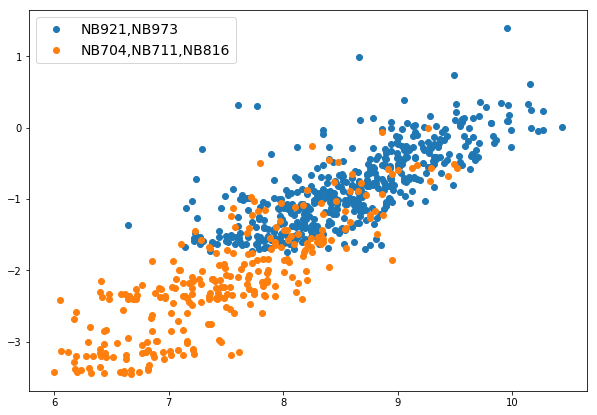

In [158]:
# [z_sp>0.3] is same as high_z = np.array([x for x in range(len(ffs)) if 'NB9' in ffs[x]])
plt.plot(mass[z_sp>0.3], sfrs[z_sp>0.3], 'o', label='NB921,NB973')
plt.plot(mass[z_sp<=0.3], sfrs[z_sp<=0.3], 'o', label='NB704,NB711,NB816')

plt.gcf().set_size_inches(10,7)
plt.legend(fontsize=14)

In [162]:
a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, old_chi2_arr, chi2_arr = [],[],[],[],[],[],[],[],[]
# m_char_arr = np.arange(6.1,10.5,0.1)
# m_char_arr = np.arange(9.0,9.6,0.1)
m_char_arr = np.arange(8.0,10.1,0.1)
# m_char_arr = [9.2]

for m_char in m_char_arr:
    def piecewise_linear_z(x, a1, a2, b, c):
        m = x[:,0]
        z = x[:,1]
        return np.select([m < m_char, m >= m_char], [a1*(m-m_char)+b*z+c, a2*(m-m_char)+b*z+c])
    
    guesses = (0.9, 0.5, 2.8, -1.8)
    params, pcov = optimize.curve_fit(piecewise_linear_z, mz_data[z_sp>0.3], sfrs[z_sp>0.3], p0=guesses)
    a1 = params[0]
    a2 = params[1]
    b = params[2]
    c = params[3]
    
    a_low_arr.append('%.2f'%a1+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[0])
    a_high_arr.append('%.2f'%a2+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[1])
    b_arr.append('%.2f'%b+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[2])
    c_arr.append('%.2f'%c+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[3])
    
    rss = np.sum( (sfrs[z_sp>0.3] - piecewise_linear_z(mz_data[z_sp>0.3], *params))**2 )  # residual sum of squares
    tss = np.sum((sfrs[z_sp>0.3] - np.mean(sfrs[z_sp>0.3])) ** 2)    # total sum of squares
    r2 = 1 - (rss / tss)    # r-squared
    r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
    rmse = np.std((sfrs[z_sp>0.3] - piecewise_linear_z(mz_data[z_sp>0.3], *params)))      # root mean square error
    old_chi2 = np.sum( (piecewise_linear_z(mz_data[z_sp>0.3], *params) - np.mean(sfrs[z_sp>0.3]))**2 )/np.std(sfrs[z_sp>0.3])**2
    chi2 = np.sum(((sfrs[z_sp>0.3] - piecewise_linear_z(mz_data[z_sp>0.3], *params))**2)/sigmas[z_sp>0.3]**2)

    r2_arr.append(np.around(r2,6))
    r2adj_arr.append(np.around(r2adj,6))
    rmse_arr.append(np.around(rmse,6))
    old_chi2_arr.append(np.around(old_chi2,4))
    chi2_arr.append(np.around(chi2,4))
    
tt = Table([m_char_arr, a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, 
            old_chi2_arr, np.around(np.array(old_chi2_arr)/nu,4), chi2_arr, np.around(np.array(chi2_arr)/nu,4)], 
           names=['m'+r'$_{\rm char}$', 'a'+r'$_{\rm low}$', 'a'+r'$_{\rm high}$', 'b', 'c',
                  r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
                  'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

m$_{\rm char}$,a$_{\rm low}$,a$_{\rm high}$,b,c,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,str14,str13,str13,str14,float64,float64,float64,float64,float64,float64,float64
8.0,-0.01$\pm$0.09,0.70$\pm$0.03,3.21$\pm$0.38,-2.68$\pm$0.16,0.657353,0.655578,0.322393,328.6766,0.4252,214832.1269,277.92
8.1,0.08$\pm$0.08,0.71$\pm$0.03,3.22$\pm$0.38,-2.63$\pm$0.16,0.657056,0.655279,0.322533,328.5281,0.425,217139.4527,280.9049
8.2,0.16$\pm$0.07,0.73$\pm$0.03,3.24$\pm$0.38,-2.59$\pm$0.16,0.656148,0.654367,0.322959,328.0742,0.4244,220053.675,284.6749
8.3,0.23$\pm$0.06,0.74$\pm$0.03,3.27$\pm$0.38,-2.54$\pm$0.16,0.654226,0.652435,0.323861,327.1132,0.4232,223567.582,289.2207
8.4,0.28$\pm$0.05,0.75$\pm$0.04,3.31$\pm$0.38,-2.50$\pm$0.16,0.652826,0.651027,0.324516,326.413,0.4223,227098.7235,293.7888
8.5,0.32$\pm$0.05,0.78$\pm$0.04,3.36$\pm$0.38,-2.47$\pm$0.16,0.652856,0.651057,0.324502,326.428,0.4223,231071.468,298.9282
8.6,0.35$\pm$0.04,0.79$\pm$0.04,3.41$\pm$0.38,-2.43$\pm$0.17,0.65176,0.649956,0.325014,325.88,0.4216,235492.1265,304.647
8.7,0.39$\pm$0.04,0.81$\pm$0.05,3.43$\pm$0.38,-2.37$\pm$0.17,0.649104,0.647286,0.326251,324.5519,0.4199,239091.7835,309.3037
8.8,0.43$\pm$0.04,0.81$\pm$0.05,3.43$\pm$0.38,-2.30$\pm$0.17,0.645303,0.643465,0.328013,322.6516,0.4174,240164.7485,310.6918
